In [1]:
import numpy as np
import pandas as pd

In [2]:
import zipfile
import os

zip_path = "/content/aggTrade-20250411T104252Z-001.zip"
extract_path = "/content/data/aggTrade"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"✅ Extracted to: {extract_path}")


zip_path2 = "/content/depth20_1000ms-20250411T104253Z-001.zip"
extract_path2 = "/content/data/depth_20"

with zipfile.ZipFile(zip_path2, 'r') as zip_ref:
    zip_ref.extractall(extract_path2)

print(f"✅ Extracted to: {extract_path2}")

✅ Extracted to: /content/data/aggTrade
✅ Extracted to: /content/data/depth_20


In [3]:
import pandas as pd
import os

def clean_and_parse_time(df, time_col):
    df[time_col] = df[time_col].str.replace(r"\s\+\d+\s\w+", "", regex=True)
    df[time_col] = pd.to_datetime(df[time_col])
    return df

def load_and_concat_txts(folder_path, time_col):
    files = sorted(os.listdir(folder_path))
    dfs = []

    for file in files:
        if file.endswith(".txt"):
            df = pd.read_csv(os.path.join(folder_path, file))
            df = clean_and_parse_time(df, time_col)
            dfs.append(df)

    combined_df = pd.concat(dfs).sort_values(by=time_col).reset_index(drop=True)
    return combined_df

aggtrade_df = load_and_concat_txts("/content/data/aggTrade/aggTrade", time_col="Time")
print(f"✅ aggTrade shape: {aggtrade_df.shape}")
aggtrade_df.head()

depth20_df = load_and_concat_txts("/content/data/depth_20/depth20_1000ms", time_col="Time")
print(f"✅ depth20 shape: {depth20_df.shape}")
depth20_df.head()


✅ aggTrade shape: (933417, 6)
✅ depth20 shape: (338519, 81)


,Time,BidPriceL20,BidQtyL20,BidPriceL19,BidQtyL19,BidPriceL18,BidQtyL18,BidPriceL17,BidQtyL17,BidPriceL16,...,AskPriceL16,AskQtyL16,AskPriceL17,AskQtyL17,AskPriceL18,AskQtyL18,AskPriceL19,AskQtyL19,AskPriceL20,AskQtyL20
0,2025-03-14 00:00:02.292522546,579.20,0.621,579.24,0.015,579.25,0.009,579.26,0.013,579.27,...,579.67,1.151,579.68,0.043,579.69,1.258,579.70,0.911,579.71,2.025
1,2025-03-14 00:00:03.292828523,579.08,2.612,579.09,8.606,579.10,3.453,579.11,3.825,579.12,...,579.59,0.971,579.60,5.071,579.61,4.894,579.62,1.017,579.63,0.048
2,2025-03-14 00:00:04.292889586,579.14,1.948,579.15,3.957,579.18,1.681,579.19,3.465,579.20,...,579.62,1.017,579.63,0.048,579.64,9.720,579.65,2.025,579.66,0.365
3,2025-03-14 00:00:05.292551566,579.07,0.013,579.08,0.013,579.09,8.606,579.10,3.453,579.11,...,579.56,0.024,579.57,1.926,579.58,2.127,579.59,0.279,579.60,7.213
4,2025-03-14 00:00:06.292725093,579.11,9.143,579.12,6.361,579.13,5.837,579.14,2.816,579.15,...,579.56,0.024,579.57,1.926,579.58,2.127,579.59,0.279,579.60,10.469


In [4]:
def compute_depth_features(depth_df):
    depth_df['Time'] = pd.to_datetime(depth_df['Time'])

    bid_price_1 = depth_df['BidPriceL1']
    bid_qty_1 = depth_df['BidQtyL1']
    ask_price_1 = depth_df['AskPriceL1']
    ask_qty_1 = depth_df['AskQtyL1']

    depth_df['bid_ask_spread'] = ask_price_1 - bid_price_1

    depth_df['imbalance_lvl1'] = (bid_qty_1 - ask_qty_1) / (bid_qty_1 + ask_qty_1 + 1e-9)
    depth_df['microprice'] = (bid_price_1 * ask_qty_1 + ask_price_1 * bid_qty_1) / (bid_qty_1 + ask_qty_1 + 1e-9)

    bid_qty_cols = [f'BidQtyL{i}' for i in range(1, 21)]
    ask_qty_cols = [f'AskQtyL{i}' for i in range(1, 21)]

    depth_df['cum_bid_qty'] = depth_df[bid_qty_cols].sum(axis=1)
    depth_df['cum_ask_qty'] = depth_df[ask_qty_cols].sum(axis=1)

    depth_df['mid_price'] = (bid_price_1 + ask_price_1) / 2

    depth_df['log_return'] = np.log(depth_df['mid_price'] / depth_df['mid_price'].shift(1))

    depth_df['volatility_10s'] = depth_df['log_return'].rolling(10_000, min_periods=1).std()
    depth_df['volatility_30s'] = depth_df['log_return'].rolling(30_000, min_periods=1).std()

    depth_df['sloped_bid_depth'] = (depth_df['BidQtyL1'] - depth_df['BidQtyL5']) / 4
    depth_df['sloped_ask_depth'] = (depth_df['AskQtyL5'] - depth_df['AskQtyL1']) / 4

    return depth_df


In [5]:
depth20_df = compute_depth_features(depth20_df)

depth20_df[['Time', 'bid_ask_spread', 'imbalance_lvl1', 'microprice',
          'cum_bid_qty', 'cum_ask_qty', 'log_return',
          'volatility_10s', 'volatility_30s', 'sloped_bid_depth', 'sloped_ask_depth']].head()

,Time,bid_ask_spread,imbalance_lvl1,microprice,cum_bid_qty,cum_ask_qty,log_return,volatility_10s,volatility_30s,sloped_bid_depth,sloped_ask_depth
0,2025-03-14 00:00:02.292522546,0.08,0.000000,579.480000,57.149,29.514,NaN,NaN,NaN,0.00000,-0.23425
1,2025-03-14 00:00:03.292828523,0.08,0.000000,579.400000,88.726,30.428,-0.000138,NaN,NaN,-1.06425,0.06625
2,2025-03-14 00:00:04.292889586,0.08,-0.098286,579.406068,32.426,46.398,0.000017,0.000110,0.000110,-0.67800,-0.06725
3,2025-03-14 00:00:05.292551566,0.06,0.000000,579.340000,61.843,44.543,-0.000121,0.000085,0.000085,0.23700,-0.05775
4,2025-03-14 00:00:06.292725093,0.05,0.000000,579.345000,53.561,45.245,0.000009,0.000083,0.000083,0.06725,-0.05775


In [6]:

def compute_volume_features(agg_df, window_10s=10, window_30s=30):
    agg_df['Time'] = pd.to_datetime(agg_df['Time'])
    agg_df.sort_values('Time', inplace=True)

    agg_df['BuyVolume'] = agg_df.apply(lambda row: row['Quantity'] if not row['IsMarketMaker'] else 0, axis=1)
    agg_df['SellVolume'] = agg_df.apply(lambda row: row['Quantity'] if row['IsMarketMaker'] else 0, axis=1)

    agg_df.set_index('Time', inplace=True)
    resampled = agg_df.resample('1s').agg({
        'BuyVolume': 'sum',
        'SellVolume': 'sum',
        'Price': lambda x: np.average(x, weights=agg_df.loc[x.index, 'Quantity']) if len(x) > 0 else np.nan,
        'Quantity': 'sum',
        'NumTrades': 'sum'
    }).fillna(0)

    resampled['VWAP'] = resampled['Price']
    resampled.drop(columns='Price', inplace=True)

    resampled['vol_imbalance'] = (resampled['BuyVolume'] - resampled['SellVolume']) / (
        resampled['BuyVolume'] + resampled['SellVolume'] + 1e-9)

    resampled['cum_volume_10s'] = resampled['Quantity'].rolling(window_10s).sum()
    resampled['cum_volume_30s'] = resampled['Quantity'].rolling(window_30s).sum()

    resampled['vwap_shift_10s'] = resampled['VWAP'].diff(window_10s)
    resampled['vwap_shift_30s'] = resampled['VWAP'].diff(window_30s)

    resampled.reset_index(inplace=True)

    return resampled


In [7]:

volume_features_df = compute_volume_features(aggtrade_df)

volume_features_df.head()

,Time,BuyVolume,SellVolume,Quantity,NumTrades,VWAP,vol_imbalance,cum_volume_10s,cum_volume_30s,vwap_shift_10s,vwap_shift_30s
0,2025-03-14 00:00:02,0.000,0.613,0.613,3,579.404274,-1.000000,NaN,NaN,NaN,NaN
1,2025-03-14 00:00:03,0.000,12.021,12.021,6,579.309173,-1.000000,NaN,NaN,NaN,NaN
2,2025-03-14 00:00:04,1.726,0.789,2.515,2,579.390588,0.372565,NaN,NaN,NaN,NaN
3,2025-03-14 00:00:05,0.000,1.726,1.726,1,579.300000,-1.000000,NaN,NaN,NaN,NaN
4,2025-03-14 00:00:06,0.000,0.000,0.000,0,0.000000,0.000000,NaN,NaN,NaN,NaN


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def normalize_and_reduce(features_df, apply_pca=True, pca_variance=0.95):

    time_col = features_df['Time'] if 'Time' in features_df.columns else None

    numeric_df = features_df.select_dtypes(include=[np.number])

    scaler = StandardScaler()
    normalized = scaler.fit_transform(numeric_df)
    normalized_df = pd.DataFrame(normalized, columns=numeric_df.columns)

    if apply_pca:
        pca = PCA(n_components=pca_variance)
        pca_components = pca.fit_transform(normalized_df)
        reduced_df = pd.DataFrame(pca_components, columns=[f'PC{i+1}' for i in range(pca_components.shape[1])])
    else:
        reduced_df = normalized_df

    if time_col is not None:
        reduced_df.insert(0, 'Time', time_col.reset_index(drop=True))

    return reduced_df, scaler, pca if apply_pca else None


In [9]:
combined_df = pd.merge_asof(
    depth20_df.sort_values('Time'),
    volume_features_df.sort_values('Time'),
    on='Time',
    direction='nearest',
    tolerance=pd.Timedelta('1s')
).dropna()

print(f"✅ Combined shape with 1s tolerance: {combined_df.shape}")


✅ Combined shape with 1s tolerance: (338479, 102)


In [10]:
final_features_df, scaler, pca_model = normalize_and_reduce(combined_df, apply_pca=True)

final_features_df.head()


,Time,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46
0,2025-03-14 00:00:32.292399450,-8.214262,1.734597,-0.282365,-0.233889,0.483697,0.263418,0.586391,1.342772,1.581222,...,0.029275,0.077270,0.182717,0.268376,0.358232,0.440272,0.285201,0.527681,0.141153,-0.225632
1,2025-03-14 00:00:33.292424208,-8.075941,-0.123953,1.218356,-0.200034,-1.086276,-0.985816,-1.724871,2.269669,1.634724,...,0.494441,-0.067021,0.285742,0.421871,0.483599,-0.105766,0.197963,0.361492,0.029281,0.099609
2,2025-03-14 00:00:34.292682671,-8.092369,1.925743,-0.066010,-0.239443,-0.035291,-0.243254,-0.259116,1.513725,1.574841,...,-0.034315,0.202727,0.108467,0.037395,0.451642,0.285856,-0.332896,-0.249568,0.088196,-0.100023
3,2025-03-14 00:00:35.292878883,-8.143842,2.067127,-0.612454,-0.124171,0.316264,0.165348,0.309678,0.759814,2.233154,...,-0.115695,0.040792,-0.205497,-1.252294,-1.196215,-0.841946,0.188538,-0.120214,-0.237176,0.046699
4,2025-03-14 00:00:36.292334043,-8.098193,2.224301,-0.712345,-0.394091,0.833615,0.462902,0.745178,1.763387,2.139473,...,-0.136039,0.283909,0.127777,0.156841,0.210446,-0.013443,0.278418,0.336756,0.060945,0.019963


In [11]:
X = final_features_df.drop(columns=['Time'], errors='ignore')


K = 2, Time = 1.96s
K = 3, Time = 1.39s
K = 4, Time = 1.36s
K = 5, Time = 1.41s
K = 6, Time = 1.43s
K = 7, Time = 1.40s
K = 8, Time = 1.45s
K = 9, Time = 1.47s
K = 10, Time = 2.04s


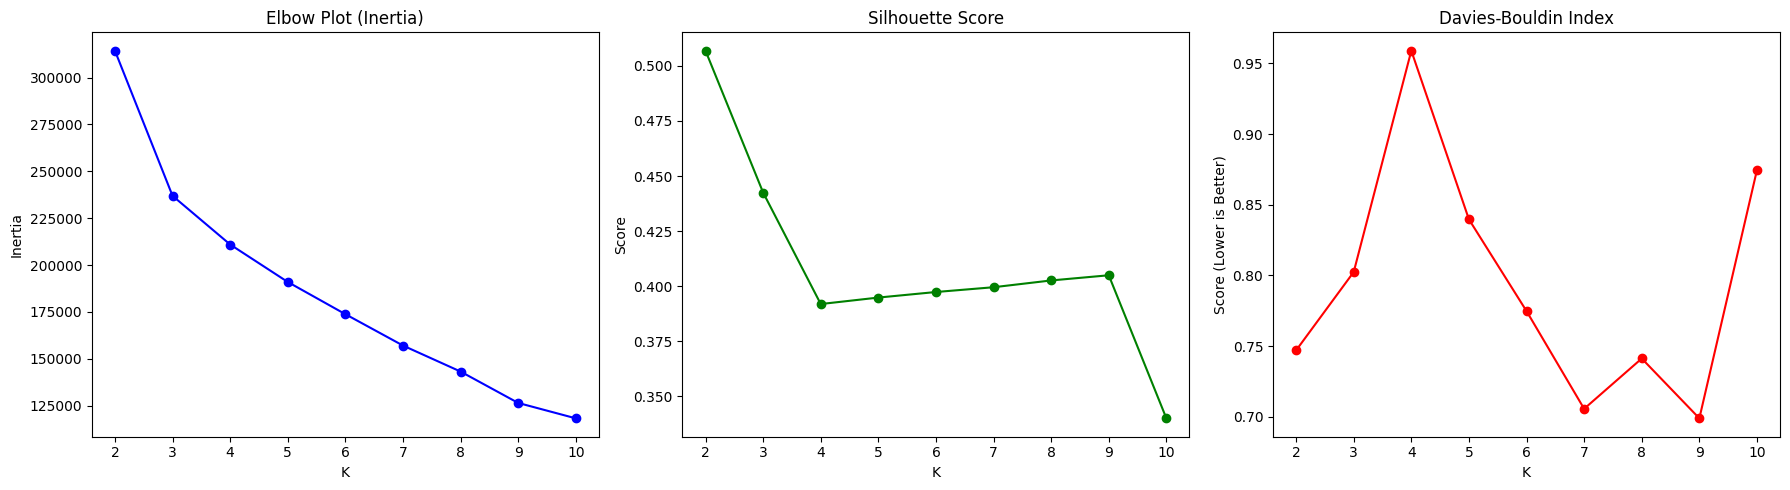

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

X_sample = X.sample(n=10000, random_state=42)

pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X_sample)

inertia = []
sil_scores = []
db_scores = []
K_range = range(2, 11)

for k in K_range:
    start = time.time()
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, algorithm='elkan')
    labels = kmeans.fit_predict(X_pca)

    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_pca, labels))
    db_scores.append(davies_bouldin_score(X_pca, labels))

    print(f"K = {k}, Time = {time.time() - start:.2f}s")

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(K_range, inertia, 'bo-')
plt.title('Elbow Plot (Inertia)')
plt.xlabel('K')
plt.ylabel('Inertia')

plt.subplot(1, 3, 2)
plt.plot(K_range, sil_scores, 'go-')
plt.title('Silhouette Score')
plt.xlabel('K')
plt.ylabel('Score')

plt.subplot(1, 3, 3)
plt.plot(K_range, db_scores, 'ro-')
plt.title('Davies-Bouldin Index')
plt.xlabel('K')
plt.ylabel('Score (Lower is Better)')

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Silhouette Score: 0.5478
Davies-Bouldin Index: 0.4495


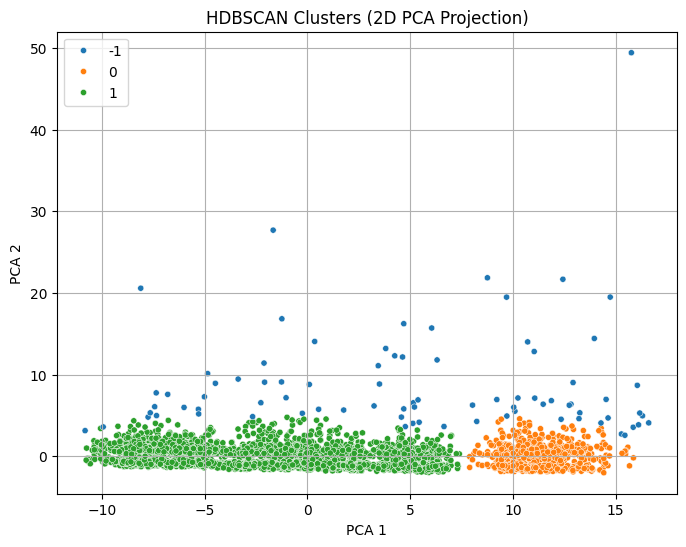

In [13]:
from sklearn.decomposition import PCA
import hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score

pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(X)

X_sample = X_reduced[np.random.choice(X_reduced.shape[0], size=5000, replace=False)]

clusterer = hdbscan.HDBSCAN(min_cluster_size=15)
labels = clusterer.fit_predict(X_sample)

mask = labels != -1
if mask.sum() > 0:
    sil = silhouette_score(X_sample[mask], labels[mask])
    db = davies_bouldin_score(X_sample[mask], labels[mask])
    print(f"Silhouette Score: {sil:.4f}")
    print(f"Davies-Bouldin Index: {db:.4f}")
else:
    print("No clusters found")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_sample[:, 0], y=X_sample[:, 1], hue=labels, palette='tab10', s=20)
plt.title("HDBSCAN Clusters (2D PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


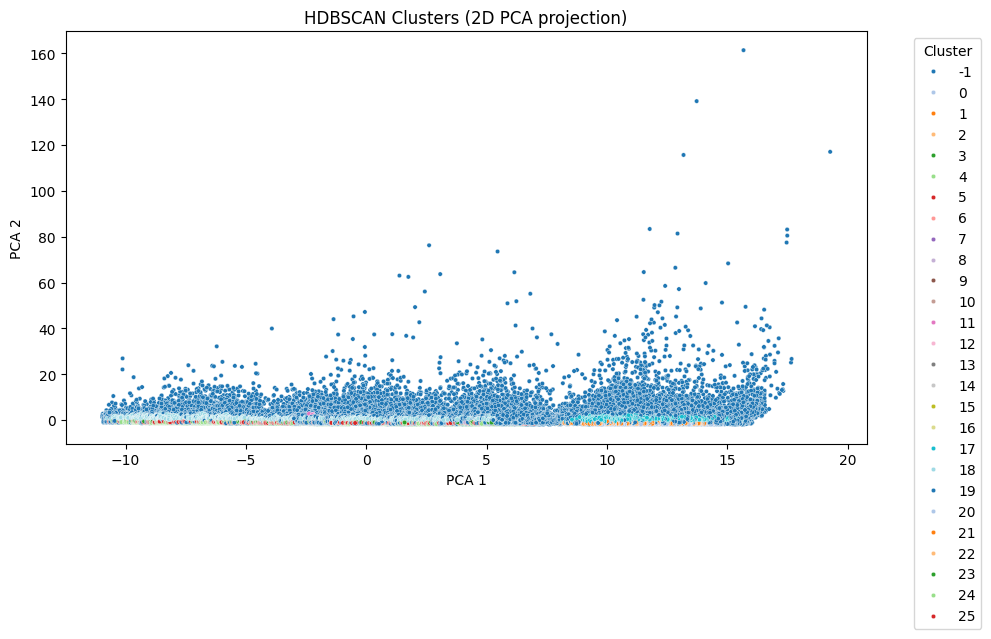

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import hdbscan

X_np = X.values if isinstance(X, pd.DataFrame) else X

pca = PCA(n_components=10, random_state=42)
X_reduced = pca.fit_transform(X_np)

clusterer = hdbscan.HDBSCAN(min_cluster_size=30, metric='euclidean')
labels_hdb = clusterer.fit_predict(X_reduced)

pca_vis = PCA(n_components=2, random_state=42)
X_2D = pca_vis.fit_transform(X_np)

plt.figure(figsize=(10, 6))
palette = sns.color_palette("tab20", n_colors=len(set(labels_hdb)))
sns.scatterplot(x=X_2D[:, 0], y=X_2D[:, 1], hue=labels_hdb, palette=palette, s=10, legend='full')
plt.title("HDBSCAN Clusters (2D PCA projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [15]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=42)
labels_gmm = gmm.fit_predict(X)

sil_gmm = silhouette_score(X, labels_gmm)
db_gmm = davies_bouldin_score(X, labels_gmm)

print(f"🔹 GMM with {3} components")
print(f"Silhouette Score: {sil_gmm}")
print(f"Davies-Bouldin Index: {db_gmm}")


🔹 GMM with 3 components
Silhouette Score: 0.01702078925580191
Davies-Bouldin Index: 6.1695155737976215


🔄 Applying PCA...


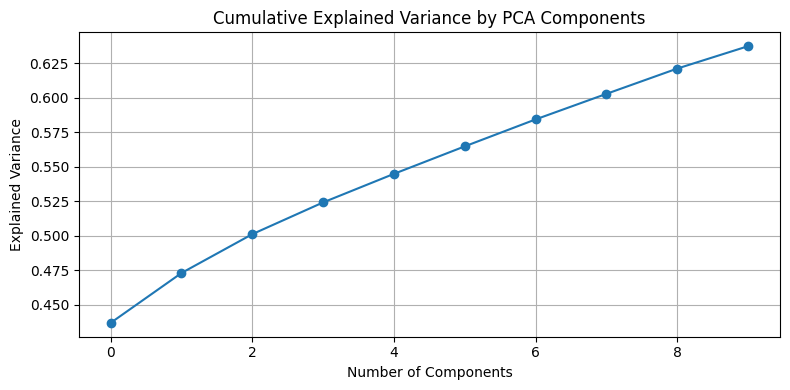

📦 Running Gaussian Mixture Model (optimized)...
Initialization 0
Initialization converged.
⏱️ GMM fit time: 0.79 seconds

🔹 GMM with 3 components
📊 Silhouette Score: 0.0513
📉 Davies-Bouldin Index: 4.2631


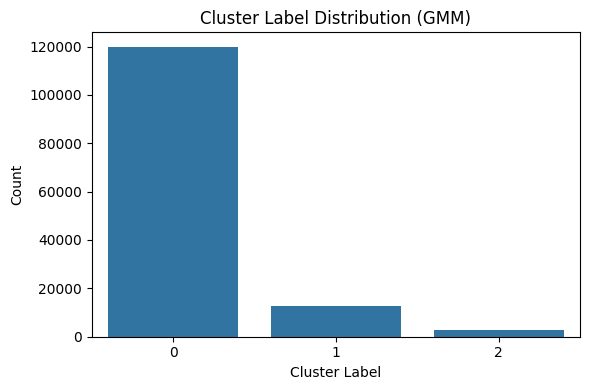

📌 Visualizing GMM Clusters in 2D PCA space...


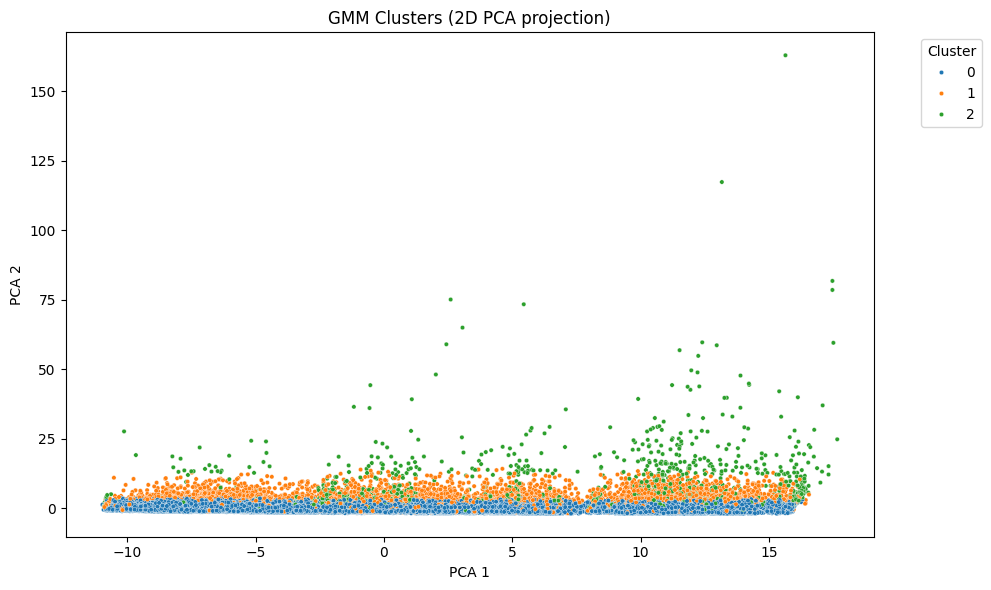

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score

X_sampled = X.sample(frac=0.4, random_state=42) if isinstance(X, pd.DataFrame) else X

print("🔄 Applying PCA...")
pca = PCA(n_components=10, random_state=42)
X_reduced = pca.fit_transform(X_sampled)

plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

print("📦 Running Gaussian Mixture Model (optimized)...")
start = time.time()
gmm = GaussianMixture(n_components=3, covariance_type='diag', max_iter=100, random_state=42, verbose=1)
labels_gmm = gmm.fit_predict(X_reduced)
end = time.time()
print(f"⏱️ GMM fit time: {end - start:.2f} seconds")

sil_gmm = silhouette_score(X_reduced, labels_gmm)
db_gmm = davies_bouldin_score(X_reduced, labels_gmm)

print(f"\n🔹 GMM with 3 components")
print(f"📊 Silhouette Score: {sil_gmm:.4f}")
print(f"📉 Davies-Bouldin Index: {db_gmm:.4f}")

plt.figure(figsize=(6, 4))
sns.countplot(x=labels_gmm)
plt.title("Cluster Label Distribution (GMM)")
plt.xlabel("Cluster Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

print("📌 Visualizing GMM Clusters in 2D PCA space...")
pca_vis = PCA(n_components=2, random_state=42)
X_2D = pca_vis.fit_transform(X_sampled)

plt.figure(figsize=(10, 6))
palette = sns.color_palette("tab10", n_colors=len(set(labels_gmm)))
sns.scatterplot(x=X_2D[:, 0], y=X_2D[:, 1], hue=labels_gmm, palette=palette, s=10, legend='full')
plt.title("GMM Clusters (2D PCA projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


🔄 Applying PCA to reduce to 2D...
✅ PCA done in 0.10 seconds
📦 Running Gaussian Mixture Model...
✅ GMM done in 2.49 seconds

🔹 GMM with 3 components
📊 Silhouette Score: 0.3082
📉 Davies-Bouldin Index: 1.3767


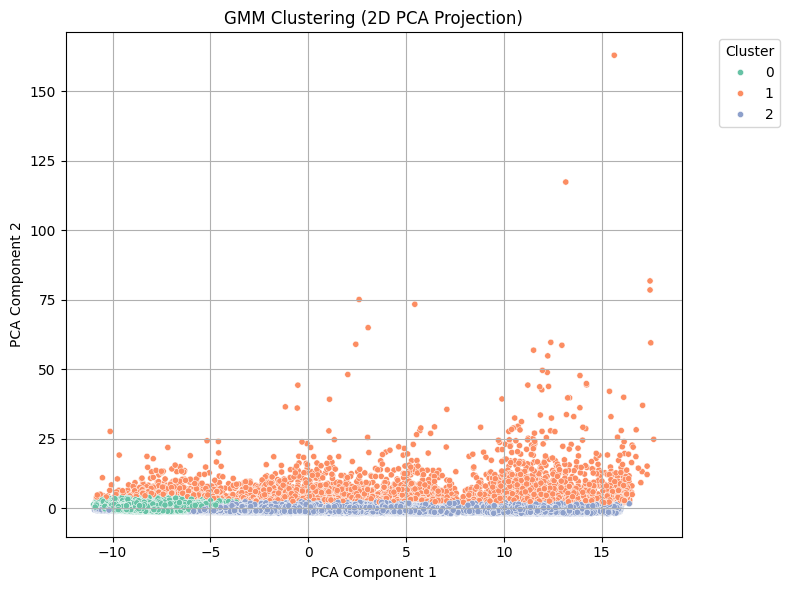

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score

if isinstance(X, pd.DataFrame):
    X_sample = X.sample(frac=0.4, random_state=42)
else:
    sample_size = int(X.shape[0] * 0.4)
    indices = np.random.RandomState(42).choice(X.shape[0], sample_size, replace=False)
    X_sample = X[indices]

print("🔄 Applying PCA to reduce to 2D...")
start_pca = time.time()
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_sample)
end_pca = time.time()
print(f"✅ PCA done in {end_pca - start_pca:.2f} seconds")

print("📦 Running Gaussian Mixture Model...")
start_gmm = time.time()
gmm = GaussianMixture(n_components=3, covariance_type='diag', random_state=42)
labels_gmm = gmm.fit_predict(X_2d)
end_gmm = time.time()
print(f"✅ GMM done in {end_gmm - start_gmm:.2f} seconds")

sil_gmm = silhouette_score(X_2d, labels_gmm)
db_gmm = davies_bouldin_score(X_2d, labels_gmm)

print(f"\n🔹 GMM with 3 components")
print(f"📊 Silhouette Score: {sil_gmm:.4f}")
print(f"📉 Davies-Bouldin Index: {db_gmm:.4f}")

plt.figure(figsize=(8, 6))
palette = sns.color_palette("Set2", np.unique(labels_gmm).max() + 1)
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=labels_gmm, palette=palette, legend='full', s=20)
plt.title("GMM Clustering (2D PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
X_sampled['cluster'] = labels_gmm
cluster_summary = X_sampled.groupby('cluster').mean()
print(cluster_summary.T)


cluster         0         1         2
PC1     -7.586213  5.729388  2.491989
PC2      0.372001  5.395267 -0.448326
PC3     -0.134940  1.186233 -0.014017
PC4     -0.061213  0.197458  0.009359
PC5      0.066402 -0.310933 -0.002094
PC6      0.000309 -0.401756  0.016053
PC7      0.097551 -0.406816 -0.002833
PC8      0.331392  0.286772 -0.137173
PC9      0.291849  0.008979 -0.111269
PC10    -0.221786  0.019791  0.080781
PC11    -0.012767  0.048000  0.000112
PC12    -0.002774  0.006315  0.003188
PC13     0.072949  0.052669 -0.028732
PC14    -0.009804  0.008639  0.004805
PC15    -0.016970 -0.017535  0.006132
PC16    -0.015313 -0.165857  0.009227
PC17     0.009231 -0.013545 -0.005249
PC18     0.025289  0.066266 -0.010672
PC19     0.002392  0.041139 -0.002271
PC20    -0.031226  0.069990  0.010888
PC21    -0.053089  0.049254  0.015174
PC22    -0.037235 -0.048092  0.013268
PC23    -0.069582  0.235114  0.014001
PC24    -0.030412  0.067852  0.008337
PC25     0.009512 -0.004362 -0.004687
PC26     0.2

<ipython-input-19-cef53bda27af>:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


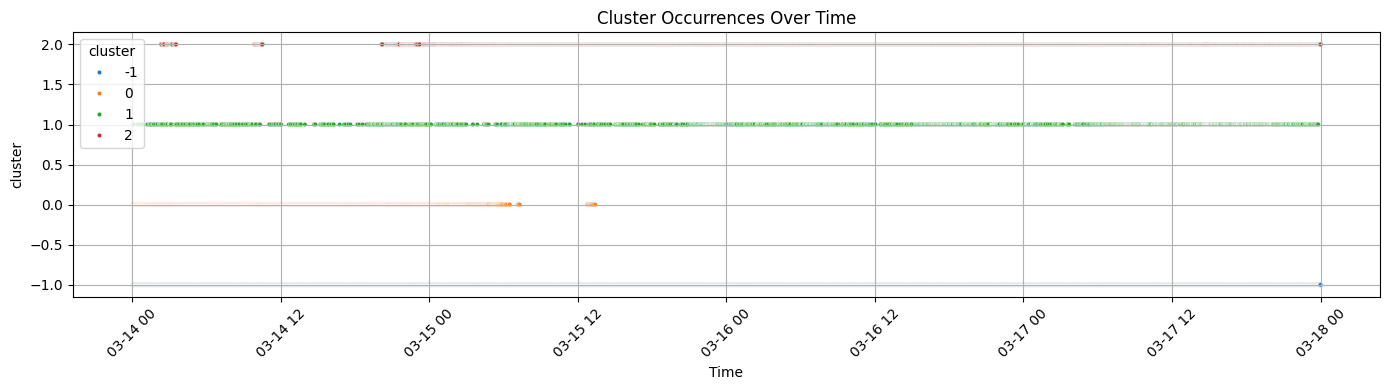

In [19]:
final_features_df['cluster'] = -1
final_features_df.loc[X_sampled.index, 'cluster'] = labels_gmm

plt.figure(figsize=(14, 4))
sns.scatterplot(data=final_features_df, x='Time', y='cluster', hue='cluster', palette='tab10', s=10)
plt.title("Cluster Occurrences Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
print(len(labels_gmm), len(X_sample))
print(final_features_df.shape)


135392 135392
(135392, 49)


In [30]:
final_features_df = final_features_df.copy()
final_features_df['regime'] = labels_gmm
print(final_features_df['regime'].value_counts())


regime
2    94802
0    35181
1     5409
Name: count, dtype: int64


In [32]:
combined_df = combined_df.iloc[X_sample.index].copy()
combined_df['regime'] = labels_gmm


In [33]:
regime_summary = combined_df.groupby('regime').agg({
    'volatility_10s': 'mean',
    'volatility_30s': 'mean',
    'bid_ask_spread': 'mean',
    'cum_bid_qty': 'mean',
    'cum_ask_qty': 'mean',
    'log_return': ['mean', 'std'],
    'microprice': ['first', 'last']
})


In [34]:
regime_summary.columns = ['_'.join(col) for col in regime_summary.columns]
regime_summary['price_change'] = (
    regime_summary['microprice_last'] - regime_summary['microprice_first']
)


In [35]:
regime_names = {
    0: "Stable & Liquid & Sideways",
    1: "Trending Up & Volatile & Illiquid",
    2: "Mean-Reverting & Moderate Liquidity"
}
regime_summary['description'] = regime_summary.index.map(regime_names)


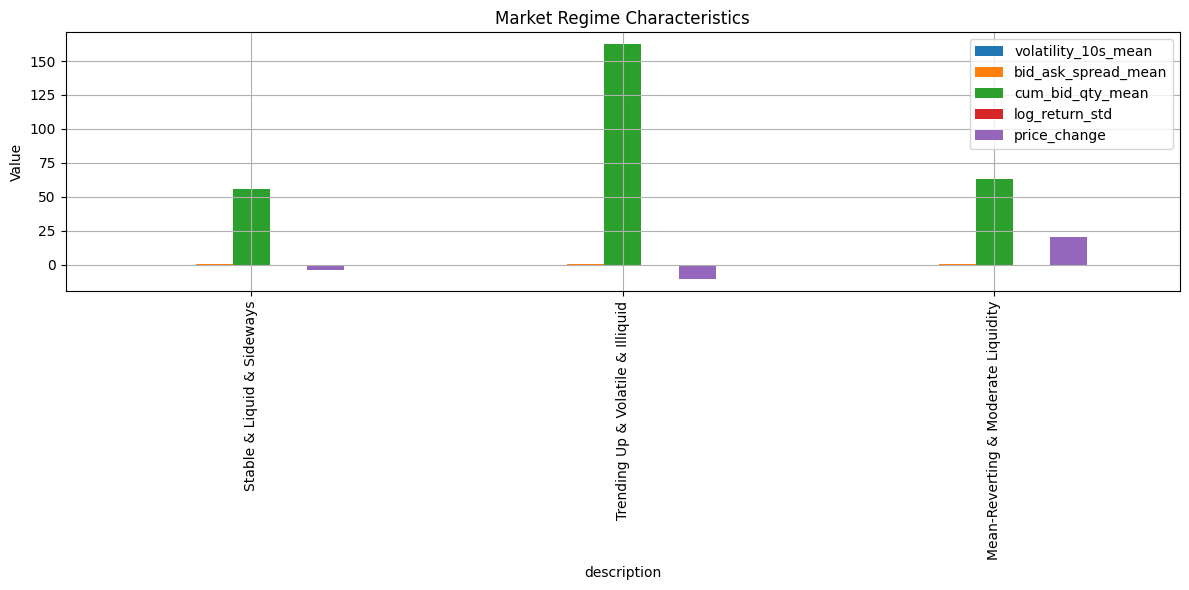

In [36]:
import matplotlib.pyplot as plt

regime_summary.set_index('description')[[
    'volatility_10s_mean', 'bid_ask_spread_mean', 'cum_bid_qty_mean',
    'log_return_std', 'price_change'
]].plot(kind='bar', figsize=(12, 6), grid=True)
plt.title("Market Regime Characteristics")
plt.ylabel("Value")
plt.tight_layout()
plt.show()


<ipython-input-37-0ccc72fb9836>:21: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


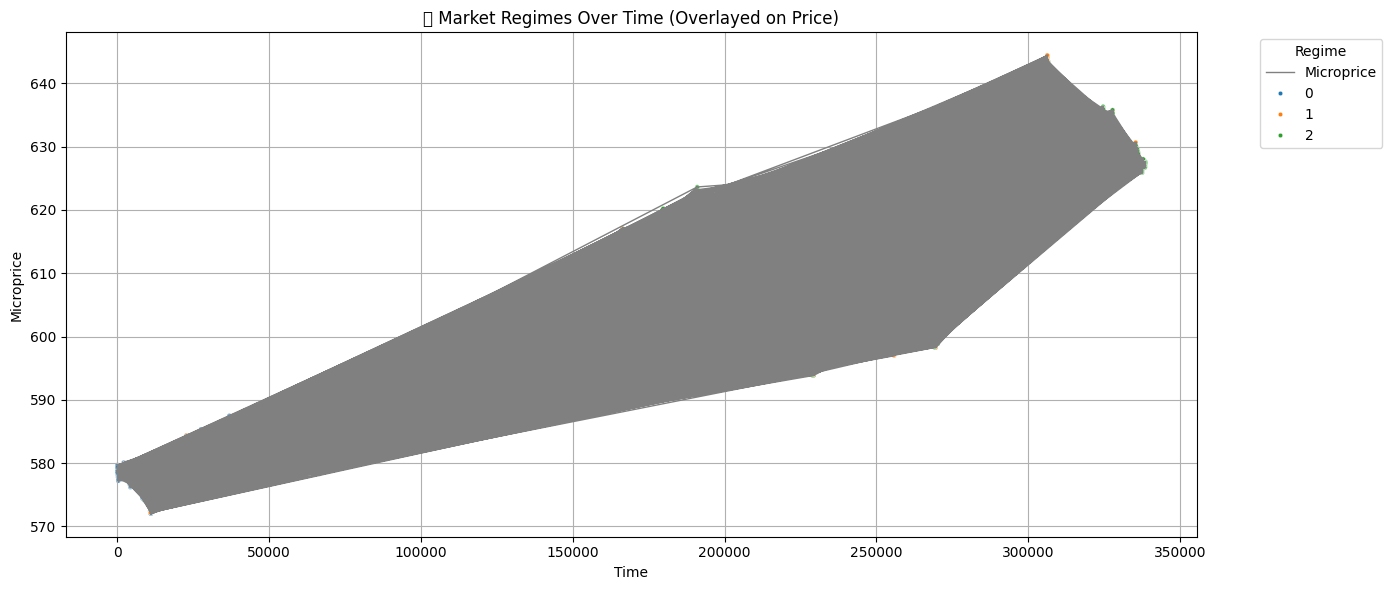

In [37]:
plt.figure(figsize=(14, 6))

plt.plot(combined_df['microprice'], label='Microprice', color='gray', linewidth=1)

sns.scatterplot(
    x=combined_df.index,
    y=combined_df['microprice'],
    hue=combined_df['regime'],
    palette='tab10',
    s=10,
    legend='full'
)

plt.title("📈 Market Regimes Over Time (Overlayed on Price)")
plt.xlabel("Time")
plt.ylabel("Microprice")
plt.legend(title="Regime", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-38-0ccc72fb9836>:21: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


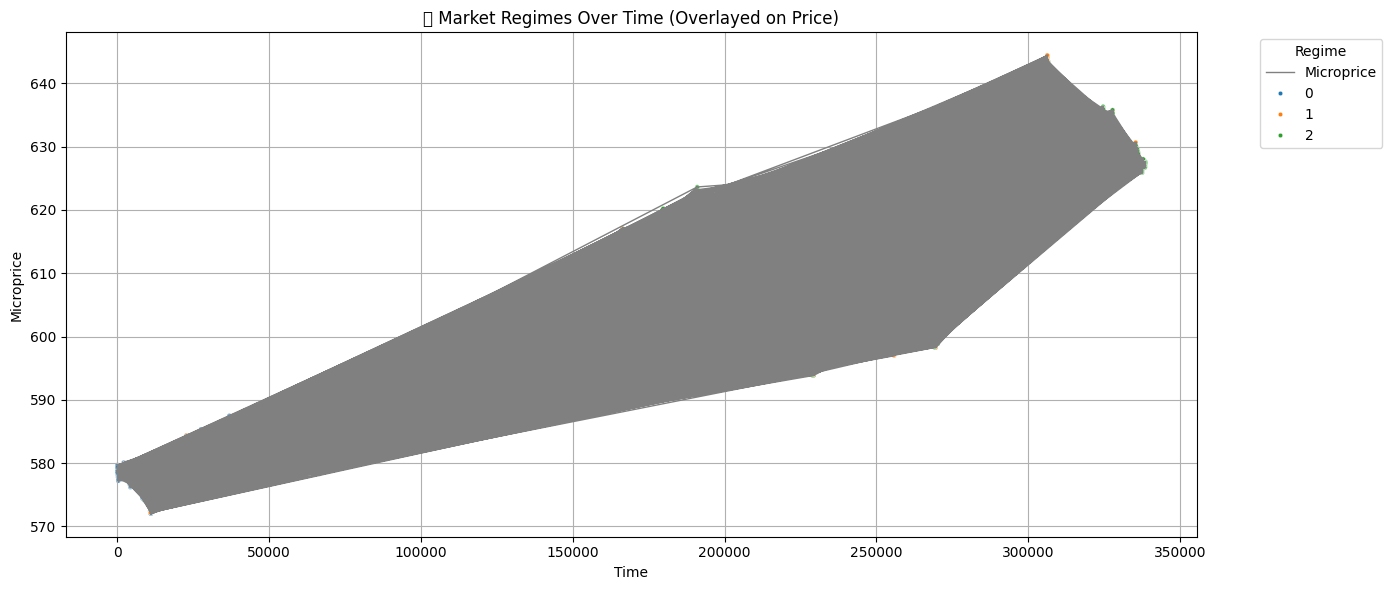

In [38]:
plt.figure(figsize=(14, 6))

plt.plot(combined_df['microprice'], label='Microprice', color='gray', linewidth=1)

sns.scatterplot(
    x=combined_df.index,
    y=combined_df['microprice'],
    hue=combined_df['regime'],
    palette='tab10',
    s=10,
    legend='full'
)

plt.title("📈 Market Regimes Over Time (Overlayed on Price)")
plt.xlabel("Time")
plt.ylabel("Microprice")
plt.legend(title="Regime", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [39]:
!pip install umap-learn


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


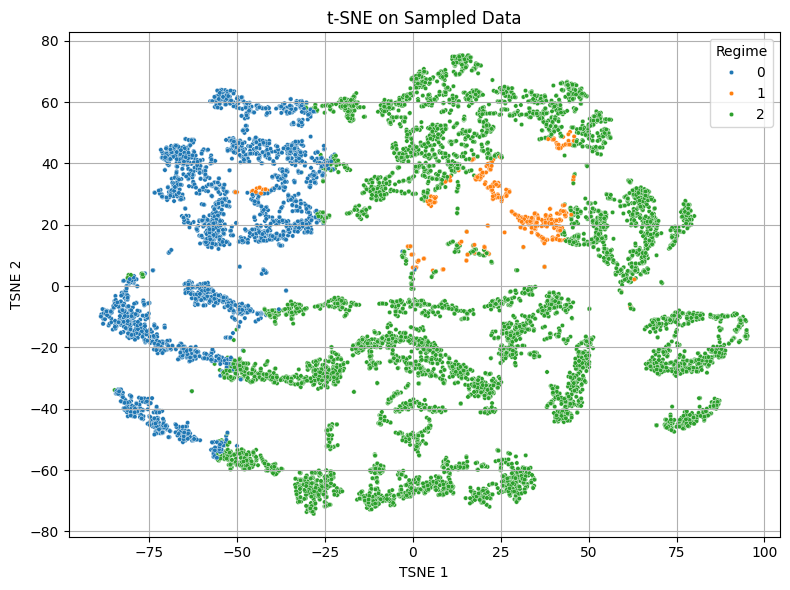

In [41]:
sample_indices = np.random.choice(X_reduced.shape[0], size=10000, replace=False)
X_tsne_sample = X_reduced[sample_indices]
labels_sample = labels_gmm[sample_indices]

tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
X_tsne = tsne.fit_transform(X_tsne_sample)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels_sample, palette='tab10', s=10)
plt.title("t-SNE on Sampled Data")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.legend(title="Regime")
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


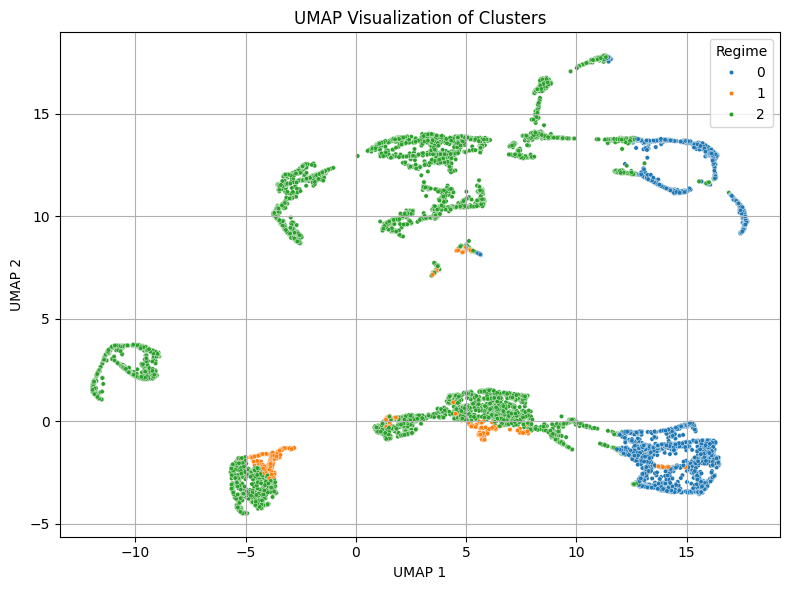

In [43]:
import umap

umap_model = umap.UMAP(n_neighbors=30, min_dist=0.1, random_state=42)
X_umap = umap_model.fit_transform(X_tsne_sample)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels_sample, palette='tab10', s=10)
plt.title("UMAP Visualization of Clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Regime")
plt.grid(True)
plt.tight_layout()
plt.show()


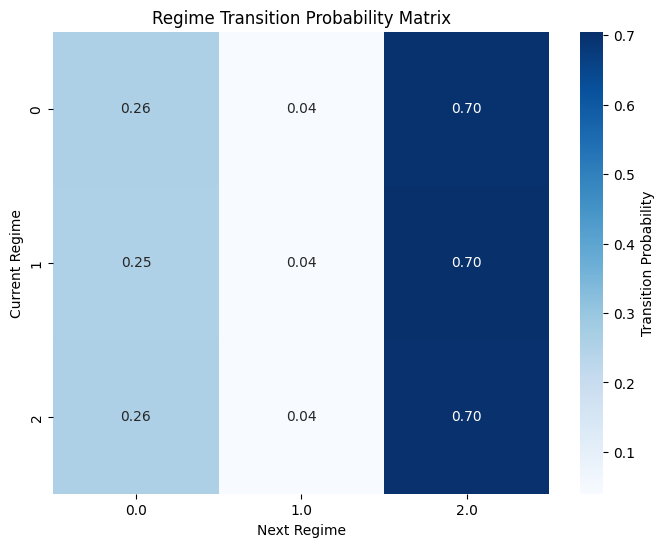

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
final_features_df['regime'] = final_features_df['regime'].astype(int)

final_features_df['next_regime'] = final_features_df['regime'].shift(-1)

transition_df = final_features_df.dropna(subset=['next_regime'])

transition_matrix = pd.crosstab(transition_df['regime'], transition_df['next_regime'], normalize='index')

plt.figure(figsize=(8, 6))
sns.heatmap(transition_matrix, annot=True, cmap='Blues', fmt='.2f', cbar_kws={'label': 'Transition Probability'})
plt.title("Regime Transition Probability Matrix")
plt.xlabel("Next Regime")
plt.ylabel("Current Regime")
plt.show()
